# Imports

In [1]:
import pandas as pd     
import numpy as np

import spacy
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm 
from itertools import product

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score, f1_score, recall_score

import matplotlib.pyplot as plt

# Functions

In [2]:
def metrics_model(list_estimators):
    results = []
    for n_est in list_estimators:
        model = RandomForestClassifier(n_estimators=n_est, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        ps = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results.append([n_est, f1, ps, recall])
    return pd.DataFrame(results, columns=['n_estimators', 'f1', 'precision', 'recall'])

In [3]:
def search_cross_valid(search_space, X_train, y_train, X_test, y_test, SEED=42):
    f1_scores, precision_s, recall, params = [], [], [], []

    for n_est, crt, max_f in tqdm(search_space, desc="Treinamento: "):
        model = RandomForestClassifier(n_estimators=n_est, criterion=crt, max_features=max_f, random_state=SEED)

        cv = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)

        steps = [('model', model)]
        pipeline = Pipeline(steps=steps)

        scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        ps = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        r = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        print('Mean f1: %.3f' % np.mean(scores))
        
        print('F1-score test: %.3f' % f1)
        print('Precision score: %.3f' % ps)
        print('Recall test: %.3f' % r)

        parm = dict(n_estimators=n_est, criterion=crt, max_features=max_f)

        print("Parameters: ", parm)
        print("Score of validation: ", np.mean(scores))

        f1_scores.append(f1)
        precision_s.append(ps)
        recall.append(r)
        params.append(parm)
        
    
    zipped_results = zip(params, f1_scores, precision_s, recall)
    best_result =  max(zipped_results, key = lambda res: res[1])
    best_params, best_f1_score, best_precision_s, best_recall = best_result
    
    results = pd.DataFrame(zip(['Random Forest'] * len(f1_scores), params, f1_scores, precision_s, recall), 
                           columns=['model', 'parameters', 'f1', 'precision', 'recall'])

    print('------------------------------')
    print("Best parameters: ", best_params)
    print("Best f1-score score: ", best_f1_score)
    print("Best precision score: ", best_precision_s)
    print("Best recall score: ", best_recall)
    
    return best_params, results

In [4]:
def plot_results(results):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(results['n_estimators'], results[['f1', 'precision', 'recall']])
    plt.xlabel("N_estimators")
    plt.ylabel('Results')
    plt.legend(['f1', 'precision', 'recall'])

# Loading the dataset

In [5]:
df = pd.read_csv("data/reviews_final.csv")

In [6]:
df.head()

,title,review,rating,date,label
0,Ótimo custo benefício.,Até agora estou amando o aparelho. Estou bem s...,5.0,25/10/2019,Good
1,Não recebi a versão global e produto veio sem ...,"Adquiri o produto em 09/11, chegou hoje e para...",1.0,14/11/2019,Bad
2,"Bom, bonito e barato. Porém sem nota fiscal!",Comprei o celular no sábado dia 26/10/19 e che...,5.0,31/10/2019,Good
3,"Bom, no prazo, carregador fora do padrão brasi...","Chegou dentro do prazo, bem embalado. Tudo ok,...",3.0,19/11/2019,Neutral
4,Celular acima das expectativas,O celular superou totalmente minhas expectativ...,5.0,29/10/2019,Good


In [7]:
df.dropna(inplace=True)

In [8]:
df['label'] = df['label'].replace('Neutral', 'Bad')

In [9]:
df['label'].value_counts()

Good    4448
Bad      320
Name: label, dtype: int64

In [10]:
df.shape

(4768, 5)

# Bag of words

In [11]:
nlp = spacy.load('pt_core_news_sm')

In [12]:
stopwords = nlp.Defaults.stop_words
len(stopwords)

416

In [13]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords)

# Models

## Parameters

In [14]:
n_estimators = list(range(10, 200, 20))
criterions = ["gini", "entropy"]
max_features = ["sqrt", "auto", "log2"]

In [15]:
search_space = tuple(product(n_estimators, criterions, max_features))

print("Amount of training sets that will be validate: ", len(search_space))

Amount of training sets that will be validate:  60


##  Model without stemming

### Splitting data into training and testing

In [16]:
X = vectorizer.fit_transform(df['review']).toarray()
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [17]:
len(X[0])

6521

### Search better n_estimators

In [18]:
results_no_stemmer = metrics_model(list(range(10, 200, 20)))

In [19]:
results_no_stemmer

,n_estimators,f1,precision,recall
0,10,0.913754,0.920717,0.932215
1,30,0.905596,0.915034,0.928721
2,50,0.906144,0.927070,0.930818
3,70,0.904723,0.925817,0.930119
4,90,0.904723,0.925817,0.930119
5,110,0.904723,0.925817,0.930119
6,130,0.902818,0.919994,0.928721
7,150,0.903286,0.924472,0.929420
8,170,0.904248,0.921570,0.929420
9,190,0.904248,0.921570,0.929420


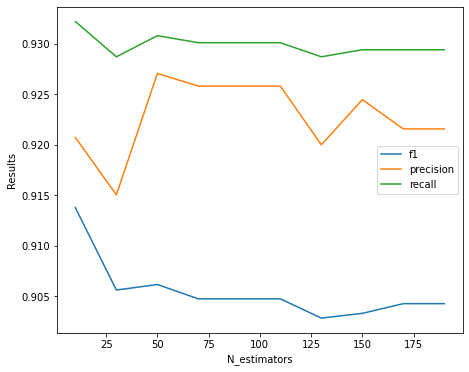

In [20]:
plot_results(results_no_stemmer)

### Instantiating model with best n_estimator

In [45]:
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [46]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.48      0.14      0.22       111
        Good       0.93      0.99      0.96      1320

    accuracy                           0.92      1431
   macro avg       0.71      0.57      0.59      1431
weighted avg       0.90      0.92      0.90      1431



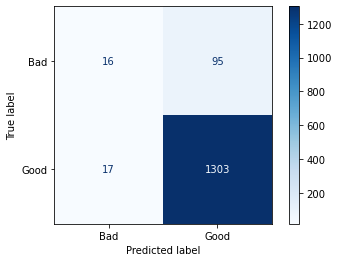

In [47]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')

## Finding better parameters

In [24]:
best_params, results = search_cross_valid(search_space, X_train, y_train, X_test, y_test)

Treinamento:   2%|█▏                                                                    | 1/60 [00:10<10:16, 10.46s/it]

Mean f1: 0.942
F1-score test: 0.914
Precision score: 0.921
Recall test: 0.932
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9418703134271997


Treinamento:   3%|██▎                                                                   | 2/60 [00:18<08:36,  8.90s/it]

Mean f1: 0.942
F1-score test: 0.914
Precision score: 0.921
Recall test: 0.932
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9418703134271997


Treinamento:   5%|███▌                                                                  | 3/60 [00:20<05:41,  6.00s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.921
Recall test: 0.926
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.938567909226592


Treinamento:   7%|████▋                                                                 | 4/60 [00:25<05:13,  5.59s/it]

Mean f1: 0.945
F1-score test: 0.912
Precision score: 0.922
Recall test: 0.932
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9445649242056426


Treinamento:   8%|█████▊                                                                | 5/60 [00:30<04:46,  5.21s/it]

Mean f1: 0.945
F1-score test: 0.912
Precision score: 0.922
Recall test: 0.932
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9445649242056426


Treinamento:  10%|███████                                                               | 6/60 [00:32<03:51,  4.29s/it]

Mean f1: 0.942
F1-score test: 0.903
Precision score: 0.911
Recall test: 0.927
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.942163420905936


Treinamento:  12%|████████▏                                                             | 7/60 [00:50<07:34,  8.58s/it]

Mean f1: 0.944
F1-score test: 0.906
Precision score: 0.915
Recall test: 0.929
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9436667206128284


Treinamento:  13%|█████████▎                                                            | 8/60 [01:03<08:47, 10.15s/it]

Mean f1: 0.944
F1-score test: 0.906
Precision score: 0.915
Recall test: 0.929
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9436667206128284


Treinamento:  15%|██████████▌                                                           | 9/60 [01:08<07:14,  8.52s/it]

Mean f1: 0.939
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385679092265917


Treinamento:  17%|███████████▌                                                         | 10/60 [01:17<07:15,  8.71s/it]

Mean f1: 0.944
F1-score test: 0.902
Precision score: 0.916
Recall test: 0.928
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9436649224074373


Treinamento:  18%|████████████▋                                                        | 11/60 [01:26<07:10,  8.80s/it]

Mean f1: 0.944
F1-score test: 0.902
Precision score: 0.916
Recall test: 0.928
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9436649224074373


Treinamento:  20%|█████████████▊                                                       | 12/60 [01:31<05:57,  7.44s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.918
Recall test: 0.925
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9385670101238963


Treinamento:  22%|██████████████▉                                                      | 13/60 [01:52<09:12, 11.76s/it]

Mean f1: 0.944
F1-score test: 0.906
Precision score: 0.927
Recall test: 0.931
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9436640233047419


Treinamento:  23%|████████████████                                                     | 14/60 [02:14<11:20, 14.80s/it]

Mean f1: 0.944
F1-score test: 0.906
Precision score: 0.927
Recall test: 0.931
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9436640233047419


Treinamento:  25%|█████████████████▎                                                   | 15/60 [02:21<09:21, 12.48s/it]

Mean f1: 0.939
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9391685098271925


Treinamento:  27%|██████████████████▍                                                  | 16/60 [02:36<09:41, 13.22s/it]

Mean f1: 0.942
F1-score test: 0.902
Precision score: 0.923
Recall test: 0.929
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9424664185143227


Treinamento:  28%|███████████████████▌                                                 | 17/60 [02:51<09:52, 13.79s/it]

Mean f1: 0.942
F1-score test: 0.902
Precision score: 0.923
Recall test: 0.929
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9424664185143227


Treinamento:  30%|████████████████████▋                                                | 18/60 [02:58<08:12, 11.72s/it]

Mean f1: 0.938
F1-score test: 0.894
Precision score: 0.931
Recall test: 0.926
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.937668806531082


Treinamento:  32%|█████████████████████▊                                               | 19/60 [03:30<12:03, 17.65s/it]

Mean f1: 0.944
F1-score test: 0.905
Precision score: 0.926
Recall test: 0.930
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9442628256999515


Treinamento:  33%|███████████████████████                                              | 20/60 [04:01<14:28, 21.72s/it]

Mean f1: 0.944
F1-score test: 0.905
Precision score: 0.926
Recall test: 0.930
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9442628256999515


Treinamento:  35%|████████████████████████▏                                            | 21/60 [04:11<11:47, 18.14s/it]

Mean f1: 0.939
F1-score test: 0.892
Precision score: 0.931
Recall test: 0.925
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385679092265917


Treinamento:  37%|█████████████████████████▎                                           | 22/60 [04:31<11:48, 18.65s/it]

Mean f1: 0.942
F1-score test: 0.900
Precision score: 0.921
Recall test: 0.928
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9418667170164177


Treinamento:  38%|██████████████████████████▍                                          | 23/60 [04:51<11:44, 19.05s/it]

Mean f1: 0.942
F1-score test: 0.900
Precision score: 0.921
Recall test: 0.928
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9418667170164177


Treinamento:  40%|███████████████████████████▌                                         | 24/60 [04:59<09:36, 16.03s/it]

Mean f1: 0.938
F1-score test: 0.895
Precision score: 0.932
Recall test: 0.927
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9382676089262916


Treinamento:  42%|████████████████████████████▊                                        | 25/60 [05:38<13:18, 22.83s/it]

Mean f1: 0.945
F1-score test: 0.905
Precision score: 0.926
Recall test: 0.930
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9445613277948608


Treinamento:  43%|█████████████████████████████▉                                       | 26/60 [06:17<15:38, 27.59s/it]

Mean f1: 0.945
F1-score test: 0.905
Precision score: 0.926
Recall test: 0.930
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9445613277948608


Treinamento:  45%|███████████████████████████████                                      | 27/60 [06:29<12:41, 23.08s/it]

Mean f1: 0.938
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.938268508028987


Treinamento:  47%|████████████████████████████████▏                                    | 28/60 [06:55<12:41, 23.79s/it]

Mean f1: 0.942
F1-score test: 0.899
Precision score: 0.926
Recall test: 0.928
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9418667170164176


Treinamento:  48%|█████████████████████████████████▎                                   | 29/60 [07:22<12:47, 24.75s/it]

Mean f1: 0.942
F1-score test: 0.899
Precision score: 0.926
Recall test: 0.928
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9418667170164176


Treinamento:  50%|██████████████████████████████████▌                                  | 30/60 [07:33<10:23, 20.79s/it]

Mean f1: 0.937
F1-score test: 0.892
Precision score: 0.931
Recall test: 0.925
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9373694053334771


Treinamento:  52%|███████████████████████████████████▋                                 | 31/60 [08:22<14:00, 29.00s/it]

Mean f1: 0.945
F1-score test: 0.905
Precision score: 0.926
Recall test: 0.930
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9451610292927659


Treinamento:  53%|████████████████████████████████████▊                                | 32/60 [09:10<16:11, 34.71s/it]

Mean f1: 0.945
F1-score test: 0.905
Precision score: 0.926
Recall test: 0.930
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9451610292927659


Treinamento:  55%|█████████████████████████████████████▉                               | 33/60 [09:25<13:00, 28.92s/it]

Mean f1: 0.938
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.938268508028987


Treinamento:  57%|███████████████████████████████████████                              | 34/60 [09:56<12:51, 29.69s/it]

Mean f1: 0.942
F1-score test: 0.898
Precision score: 0.925
Recall test: 0.927
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9415673158188127


Treinamento:  58%|████████████████████████████████████████▎                            | 35/60 [10:34<13:18, 31.93s/it]

Mean f1: 0.942
F1-score test: 0.898
Precision score: 0.925
Recall test: 0.927
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9415673158188127


Treinamento:  60%|█████████████████████████████████████████▍                           | 36/60 [10:56<11:40, 29.17s/it]

Mean f1: 0.938
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9379682077286867


Treinamento:  62%|██████████████████████████████████████████▌                          | 37/60 [12:23<17:45, 46.32s/it]

Mean f1: 0.945
F1-score test: 0.903
Precision score: 0.920
Recall test: 0.929
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9454613295930662


Treinamento:  63%|███████████████████████████████████████████▋                         | 38/60 [13:51<21:37, 59.00s/it]

Mean f1: 0.945
F1-score test: 0.903
Precision score: 0.920
Recall test: 0.929
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9454613295930662


Treinamento:  65%|████████████████████████████████████████████▊                        | 39/60 [14:20<17:26, 49.86s/it]

Mean f1: 0.939
F1-score test: 0.887
Precision score: 0.929
Recall test: 0.923
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385679092265917


Treinamento:  67%|██████████████████████████████████████████████                       | 40/60 [15:11<16:45, 50.26s/it]

Mean f1: 0.942
F1-score test: 0.902
Precision score: 0.929
Recall test: 0.929
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9415682149215083


Treinamento:  68%|███████████████████████████████████████████████▏                     | 41/60 [15:50<14:51, 46.92s/it]

Mean f1: 0.942
F1-score test: 0.902
Precision score: 0.929
Recall test: 0.929
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9415682149215083


Treinamento:  70%|████████████████████████████████████████████████▎                    | 42/60 [16:06<11:18, 37.68s/it]

Mean f1: 0.937
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9373694053334771


Treinamento:  72%|█████████████████████████████████████████████████▍                   | 43/60 [17:11<12:57, 45.72s/it]

Mean f1: 0.945
F1-score test: 0.903
Precision score: 0.924
Recall test: 0.929
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9445631260002518


Treinamento:  73%|██████████████████████████████████████████████████▌                  | 44/60 [18:15<13:40, 51.28s/it]

Mean f1: 0.945
F1-score test: 0.903
Precision score: 0.924
Recall test: 0.929
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9445631260002518


Treinamento:  75%|███████████████████████████████████████████████████▊                 | 45/60 [18:35<10:27, 41.84s/it]

Mean f1: 0.939
F1-score test: 0.887
Precision score: 0.929
Recall test: 0.923
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385679092265917


Treinamento:  77%|████████████████████████████████████████████████████▉                | 46/60 [19:17<09:46, 41.92s/it]

Mean f1: 0.942
F1-score test: 0.899
Precision score: 0.926
Recall test: 0.928
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9415673158188129


Treinamento:  78%|██████████████████████████████████████████████████████               | 47/60 [19:59<09:05, 41.96s/it]

Mean f1: 0.942
F1-score test: 0.899
Precision score: 0.926
Recall test: 0.928
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9415673158188129


Treinamento:  80%|███████████████████████████████████████████████████████▏             | 48/60 [20:17<06:58, 34.91s/it]

Mean f1: 0.937
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9373694053334771


Treinamento:  82%|████████████████████████████████████████████████████████▎            | 49/60 [21:30<08:28, 46.23s/it]

Mean f1: 0.945
F1-score test: 0.904
Precision score: 0.922
Recall test: 0.929
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9445640251029472


Treinamento:  83%|█████████████████████████████████████████████████████████▌           | 50/60 [22:42<08:59, 53.91s/it]

Mean f1: 0.945
F1-score test: 0.904
Precision score: 0.922
Recall test: 0.929
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9445640251029472


Treinamento:  85%|██████████████████████████████████████████████████████████▋          | 51/60 [23:04<06:40, 44.46s/it]

Mean f1: 0.939
F1-score test: 0.889
Precision score: 0.930
Recall test: 0.924
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385679092265917


Treinamento:  87%|███████████████████████████████████████████████████████████▊         | 52/60 [23:53<06:05, 45.66s/it]

Mean f1: 0.941
F1-score test: 0.901
Precision score: 0.934
Recall test: 0.929
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9406691122259984


Treinamento:  88%|████████████████████████████████████████████████████████████▉        | 53/60 [24:41<05:25, 46.53s/it]

Mean f1: 0.941
F1-score test: 0.901
Precision score: 0.934
Recall test: 0.929
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9406691122259984


Treinamento:  90%|██████████████████████████████████████████████████████████████       | 54/60 [25:02<03:53, 38.84s/it]

Mean f1: 0.937
F1-score test: 0.892
Precision score: 0.931
Recall test: 0.925
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9373694053334771


Treinamento:  92%|███████████████████████████████████████████████████████████████▎     | 55/60 [26:25<04:20, 52.11s/it]

Mean f1: 0.944
F1-score test: 0.904
Precision score: 0.922
Recall test: 0.929
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9442646239053424


Treinamento:  93%|████████████████████████████████████████████████████████████████▍    | 56/60 [27:48<04:05, 61.27s/it]

Mean f1: 0.944
F1-score test: 0.904
Precision score: 0.922
Recall test: 0.929
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9442646239053424


Treinamento:  95%|█████████████████████████████████████████████████████████████████▌   | 57/60 [28:14<02:31, 50.56s/it]

Mean f1: 0.938
F1-score test: 0.889
Precision score: 0.930
Recall test: 0.924
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9379691068313821


Treinamento:  97%|██████████████████████████████████████████████████████████████████▋  | 58/60 [29:09<01:44, 52.04s/it]

Mean f1: 0.941
F1-score test: 0.901
Precision score: 0.934
Recall test: 0.929
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9409676143209078


Treinamento:  98%|███████████████████████████████████████████████████████████████████▊ | 59/60 [30:04<00:53, 53.03s/it]

Mean f1: 0.941
F1-score test: 0.901
Precision score: 0.934
Recall test: 0.929
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9409676143209078


Treinamento: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [30:28<00:00, 30.48s/it]

Mean f1: 0.937
F1-score test: 0.890
Precision score: 0.930
Recall test: 0.925
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9373694053334771
------------------------------
Best parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'sqrt'}
Best f1-score score:  0.9137540660691036
Best precision score:  0.920716708789918
Best recall score:  0.9322152341020266


In [25]:
results

,model,parameters,f1,precision,recall
0,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.913754,0.920717,0.932215
1,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.913754,0.920717,0.932215
2,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.894687,0.920902,0.925926
3,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.912244,0.922355,0.932215
4,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.912244,0.922355,0.932215
5,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.902831,0.911483,0.927324
6,Random Forest,"{'n_estimators': 30, 'criterion': 'gini', 'max...",0.905596,0.915034,0.928721
7,Random Forest,"{'n_estimators': 30, 'criterion': 'gini', 'max...",0.905596,0.915034,0.928721
8,Random Forest,"{'n_estimators': 30, 'criterion': 'gini', 'max...",0.890262,0.930236,0.924528
9,Random Forest,"{'n_estimators': 30, 'criterion': 'entropy', '...",0.902352,0.916070,0.928022


In [26]:
# results['model'] = 'Random Forest'
# results. to_csv('results/random_forest.csv')

### Instantiating model with best parameters

In [48]:
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=90, random_state=42)

In [49]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.65      0.15      0.25       111
        Good       0.93      0.99      0.96      1320

    accuracy                           0.93      1431
   macro avg       0.79      0.57      0.61      1431
weighted avg       0.91      0.93      0.91      1431



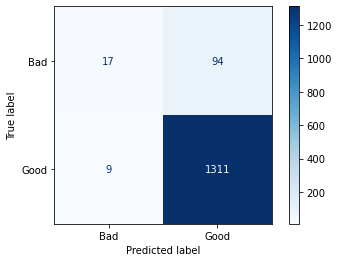

In [50]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')

# Stemming

In [27]:
reviews = df['review'].apply(lambda x: x.lower())
reviews_stemmer = []
stemmer = PorterStemmer()

for r in reviews:
    doc = nlp(r)
    sentences = doc.sents

    for sent in sentences:
        tokens = nlp(sent.text)

    # remove stop words and stemming
    review_processed = []
    
    for tkn in tokens:
        if tkn.is_punct == False and tkn.is_stop == False:
            review_processed.append(stemmer.stem(str(tkn)))

    review_text = " ".join(review_processed)
    reviews_stemmer.append(review_text)

In [28]:
reviews[0]

'até agora estou amando o aparelho. estou bem satisfeita, ainda mais com o ótimo custo benefício dele.comprei dia 16 e chegou dia 21, entrega extremamente rápida.'

In [29]:
reviews_stemmer[0]

'satisfeita ótimo custo benefício dele.comprei dia 16 chegou dia 21 entrega extremament rápida'

# Model with stemming

## Splitting data into training and testing

In [30]:
X_s = vectorizer.fit_transform(reviews_stemmer).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=.3, random_state=42)

In [31]:
len(X_s[0])

4039

In [32]:
results_stemmer = metrics_model(list(range(10, 200, 20)))

In [33]:
results_stemmer

,n_estimators,f1,precision,recall
0,10,0.901659,0.897358,0.921733
1,30,0.896849,0.892424,0.921034
2,50,0.901856,0.902231,0.924528
3,70,0.903674,0.905990,0.925926
4,90,0.906816,0.911435,0.928022
5,110,0.905491,0.909749,0.927324
6,130,0.903674,0.905990,0.925926
7,150,0.904152,0.907974,0.926625
8,170,0.902798,0.906099,0.925926
9,190,0.904152,0.907974,0.926625


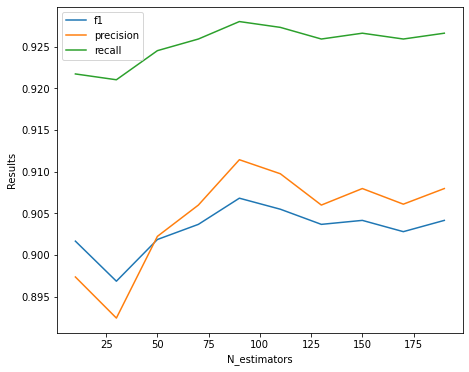

In [34]:
plot_results(results_stemmer)

In [35]:
model_stemmer = RandomForestClassifier(n_estimators=70, random_state=42)
model_stemmer.fit(X_train, y_train)

RandomForestClassifier(n_estimators=70, random_state=42)

In [36]:
print(classification_report(y_test, model_stemmer.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.60      0.14      0.22       111
        Good       0.93      0.99      0.96      1320

    accuracy                           0.93      1431
   macro avg       0.77      0.56      0.59      1431
weighted avg       0.91      0.93      0.90      1431



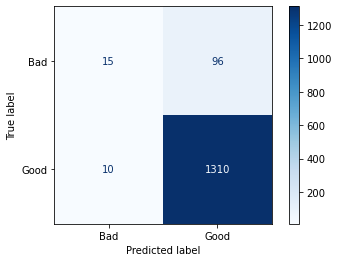

In [37]:
ConfusionMatrixDisplay.from_estimator(model_stemmer, X_test, y_test, cmap='Blues', values_format='d')

## Busca pelos melhores parametros 

In [38]:
best_params, results = search_cross_valid(search_space, X_train, y_train, X_test, y_test)

Treinamento:   2%|█▏                                                                    | 1/60 [00:04<04:24,  4.48s/it]

Mean f1: 0.931
F1-score test: 0.902
Precision score: 0.897
Recall test: 0.922
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9307744870619121


Treinamento:   3%|██▎                                                                   | 2/60 [00:09<04:21,  4.51s/it]

Mean f1: 0.931
F1-score test: 0.902
Precision score: 0.897
Recall test: 0.922
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9307744870619121


Treinamento:   5%|███▌                                                                  | 3/60 [00:11<03:13,  3.40s/it]

Mean f1: 0.936
F1-score test: 0.900
Precision score: 0.907
Recall test: 0.926
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9361673050295805


Treinamento:   7%|████▋                                                                 | 4/60 [00:14<03:16,  3.50s/it]

Mean f1: 0.933
F1-score test: 0.904
Precision score: 0.902
Recall test: 0.924
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9334690978403553


Treinamento:   8%|█████▊                                                                | 5/60 [00:18<03:15,  3.56s/it]

Mean f1: 0.933
F1-score test: 0.904
Precision score: 0.902
Recall test: 0.924
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9334690978403553


Treinamento:  10%|███████                                                               | 6/60 [00:20<02:42,  3.01s/it]

Mean f1: 0.940
F1-score test: 0.898
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9403616191041339


Treinamento:  12%|████████▏                                                             | 7/60 [00:32<05:16,  5.98s/it]

Mean f1: 0.935
F1-score test: 0.897
Precision score: 0.892
Recall test: 0.921
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9346738954523387


Treinamento:  13%|█████████▎                                                            | 8/60 [00:44<06:52,  7.94s/it]

Mean f1: 0.935
F1-score test: 0.897
Precision score: 0.892
Recall test: 0.921
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9346738954523387


Treinamento:  15%|██████████▌                                                           | 9/60 [00:49<05:55,  6.97s/it]

Mean f1: 0.939
F1-score test: 0.896
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385670101238963


Treinamento:  17%|███████████▌                                                         | 10/60 [00:58<06:27,  7.76s/it]

Mean f1: 0.939
F1-score test: 0.902
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9391676107244971


Treinamento:  18%|████████████▋                                                        | 11/60 [01:08<06:46,  8.29s/it]

Mean f1: 0.939
F1-score test: 0.902
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9391676107244971


Treinamento:  20%|█████████████▊                                                       | 12/60 [01:13<05:44,  7.18s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9391658125191059


Treinamento:  22%|██████████████▉                                                      | 13/60 [01:32<08:38, 11.03s/it]

Mean f1: 0.938
F1-score test: 0.902
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9379673086259913


Treinamento:  23%|████████████████                                                     | 14/60 [01:52<10:30, 13.71s/it]

Mean f1: 0.938
F1-score test: 0.902
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9379673086259913


Treinamento:  25%|█████████████████▎                                                   | 15/60 [02:00<08:54, 11.87s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9388664113215013


Treinamento:  27%|██████████████████▍                                                  | 16/60 [02:16<09:31, 12.99s/it]

Mean f1: 0.938
F1-score test: 0.901
Precision score: 0.904
Recall test: 0.925
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9382676089262916


Treinamento:  28%|███████████████████▌                                                 | 17/60 [02:31<09:53, 13.79s/it]

Mean f1: 0.938
F1-score test: 0.901
Precision score: 0.904
Recall test: 0.925
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9382676089262916


Treinamento:  30%|████████████████████▋                                                | 18/60 [02:39<08:19, 11.89s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9391649134164105


Treinamento:  32%|█████████████████████▊                                               | 19/60 [03:06<11:22, 16.63s/it]

Mean f1: 0.939
F1-score test: 0.904
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9385670101238963


Treinamento:  33%|███████████████████████                                              | 20/60 [03:34<13:18, 19.96s/it]

Mean f1: 0.939
F1-score test: 0.904
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9385670101238963


Treinamento:  35%|████████████████████████▏                                            | 21/60 [03:45<11:07, 17.12s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9388655122188057


Treinamento:  37%|█████████████████████████▎                                           | 22/60 [04:06<11:40, 18.43s/it]

Mean f1: 0.939
F1-score test: 0.903
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.938567909226592


Treinamento:  38%|██████████████████████████▍                                          | 23/60 [04:28<11:55, 19.35s/it]

Mean f1: 0.939
F1-score test: 0.903
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.938567909226592


Treinamento:  40%|███████████████████████████▌                                         | 24/60 [04:38<09:58, 16.61s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9394652137167109


Treinamento:  42%|████████████████████████████▊                                        | 25/60 [05:13<12:58, 22.24s/it]

Mean f1: 0.938
F1-score test: 0.907
Precision score: 0.911
Recall test: 0.928
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9382667098235962


Treinamento:  43%|█████████████████████████████▉                                       | 26/60 [05:49<14:50, 26.18s/it]

Mean f1: 0.938
F1-score test: 0.907
Precision score: 0.911
Recall test: 0.928
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9382667098235962


Treinamento:  45%|███████████████████████████████                                      | 27/60 [06:02<12:16, 22.32s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  47%|████████████████████████████████▏                                    | 28/60 [06:29<12:43, 23.85s/it]

Mean f1: 0.939
F1-score test: 0.901
Precision score: 0.907
Recall test: 0.926
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9388664113215011


Treinamento:  48%|█████████████████████████████████▎                                   | 29/60 [06:57<12:53, 24.96s/it]

Mean f1: 0.939
F1-score test: 0.901
Precision score: 0.907
Recall test: 0.926
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9388664113215011


Treinamento:  50%|██████████████████████████████████▌                                  | 30/60 [07:10<10:39, 21.33s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9388655122188055


Treinamento:  52%|███████████████████████████████████▋                                 | 31/60 [07:53<13:28, 27.87s/it]

Mean f1: 0.937
F1-score test: 0.905
Precision score: 0.910
Recall test: 0.927
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9370664077250904


Treinamento:  53%|████████████████████████████████████▊                                | 32/60 [08:36<15:08, 32.44s/it]

Mean f1: 0.937
F1-score test: 0.905
Precision score: 0.910
Recall test: 0.927
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9370664077250904


Treinamento:  55%|█████████████████████████████████████▉                               | 33/60 [08:52<12:23, 27.53s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  57%|███████████████████████████████████████                              | 34/60 [09:25<12:36, 29.08s/it]

Mean f1: 0.939
F1-score test: 0.899
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9391667116218013


Treinamento:  58%|████████████████████████████████████████▎                            | 35/60 [09:57<12:32, 30.09s/it]

Mean f1: 0.939
F1-score test: 0.899
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9391667116218013


Treinamento:  60%|█████████████████████████████████████████▍                           | 36/60 [10:12<10:15, 25.64s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9391649134164105


Treinamento:  62%|██████████████████████████████████████████▌                          | 37/60 [11:02<12:35, 32.83s/it]

Mean f1: 0.938
F1-score test: 0.904
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9382658107209003


Treinamento:  63%|███████████████████████████████████████████▋                         | 38/60 [11:52<13:54, 37.91s/it]

Mean f1: 0.938
F1-score test: 0.904
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9382658107209003


Treinamento:  65%|████████████████████████████████████████████▊                        | 39/60 [12:10<11:14, 32.13s/it]

Mean f1: 0.939
F1-score test: 0.895
Precision score: 0.900
Recall test: 0.924
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  67%|██████████████████████████████████████████████                       | 40/60 [12:49<11:18, 33.94s/it]

Mean f1: 0.938
F1-score test: 0.898
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.938266709823596


Treinamento:  68%|███████████████████████████████████████████████▏                     | 41/60 [13:27<11:08, 35.20s/it]

Mean f1: 0.938
F1-score test: 0.898
Precision score: 0.902
Recall test: 0.925
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.938266709823596


Treinamento:  70%|████████████████████████████████████████████████▎                    | 42/60 [13:45<09:00, 30.05s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9391649134164105


Treinamento:  72%|█████████████████████████████████████████████████▍                   | 43/60 [14:42<10:49, 38.21s/it]

Mean f1: 0.938
F1-score test: 0.904
Precision score: 0.908
Recall test: 0.927
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9376661092229954


Treinamento:  73%|██████████████████████████████████████████████████▌                  | 44/60 [15:39<11:42, 43.90s/it]

Mean f1: 0.938
F1-score test: 0.904
Precision score: 0.908
Recall test: 0.927
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9376661092229954


Treinamento:  75%|███████████████████████████████████████████████████▊                 | 45/60 [16:00<09:16, 37.12s/it]

Mean f1: 0.939
F1-score test: 0.891
Precision score: 0.892
Recall test: 0.922
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  77%|████████████████████████████████████████████████████▉                | 46/60 [16:45<09:09, 39.24s/it]

Mean f1: 0.938
F1-score test: 0.899
Precision score: 0.905
Recall test: 0.925
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9376670083256909


Treinamento:  78%|██████████████████████████████████████████████████████               | 47/60 [17:29<08:49, 40.73s/it]

Mean f1: 0.938
F1-score test: 0.899
Precision score: 0.905
Recall test: 0.925
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9376670083256909


Treinamento:  80%|███████████████████████████████████████████████████████▏             | 48/60 [17:50<06:56, 34.72s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  82%|████████████████████████████████████████████████████████▎            | 49/60 [18:54<08:00, 43.66s/it]

Mean f1: 0.938
F1-score test: 0.903
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9376670083256909


Treinamento:  83%|█████████████████████████████████████████████████████████▌           | 50/60 [19:58<08:18, 49.89s/it]

Mean f1: 0.938
F1-score test: 0.903
Precision score: 0.906
Recall test: 0.926
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9376670083256909


Treinamento:  85%|██████████████████████████████████████████████████████████▋          | 51/60 [20:22<06:18, 42.11s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  87%|███████████████████████████████████████████████████████████▊         | 52/60 [21:12<05:55, 44.47s/it]

Mean f1: 0.938
F1-score test: 0.899
Precision score: 0.905
Recall test: 0.925
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9379664095232958


Treinamento:  88%|████████████████████████████████████████████████████████████▉        | 53/60 [22:02<05:22, 46.05s/it]

Mean f1: 0.938
F1-score test: 0.899
Precision score: 0.905
Recall test: 0.925
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9379664095232958


Treinamento:  90%|██████████████████████████████████████████████████████████████       | 54/60 [22:26<03:55, 39.30s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9385661110212009


Treinamento:  92%|███████████████████████████████████████████████████████████████▎     | 55/60 [23:38<04:06, 49.22s/it]

Mean f1: 0.937
F1-score test: 0.904
Precision score: 0.908
Recall test: 0.927
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9373676071280862


Treinamento:  93%|████████████████████████████████████████████████████████████████▍    | 56/60 [24:51<03:44, 56.25s/it]

Mean f1: 0.937
F1-score test: 0.904
Precision score: 0.908
Recall test: 0.927
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9373676071280862


Treinamento:  95%|█████████████████████████████████████████████████████████████████▌   | 57/60 [25:18<02:22, 47.44s/it]

Mean f1: 0.938
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9382667098235962


Treinamento:  97%|██████████████████████████████████████████████████████████████████▋  | 58/60 [26:14<01:39, 50.00s/it]

Mean f1: 0.939
F1-score test: 0.900
Precision score: 0.907
Recall test: 0.926
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9388664113215011


Treinamento:  98%|███████████████████████████████████████████████████████████████████▊ | 59/60 [27:10<00:51, 51.77s/it]

Mean f1: 0.939
F1-score test: 0.900
Precision score: 0.907
Recall test: 0.926
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9388664113215011


Treinamento: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [27:36<00:00, 27.60s/it]

Mean f1: 0.939
F1-score test: 0.893
Precision score: 0.897
Recall test: 0.923
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9385670101238963
------------------------------
Best parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'sqrt'}
Best f1-score score:  0.9068161196882063
Best precision score:  0.9114351892502701
Best recall score:  0.9280223619846262


In [39]:
results

,model,parameters,f1,precision,recall
0,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.901659,0.897358,0.921733
1,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.901659,0.897358,0.921733
2,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.900000,0.907387,0.925926
3,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.903896,0.901661,0.923829
4,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.903896,0.901661,0.923829
5,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.897669,0.899591,0.923829
6,Random Forest,"{'n_estimators': 30, 'criterion': 'gini', 'max...",0.896849,0.892424,0.921034
7,Random Forest,"{'n_estimators': 30, 'criterion': 'gini', 'max...",0.896849,0.892424,0.921034
8,Random Forest,"{'n_estimators': 30, 'criterion': 'gini', 'max...",0.895625,0.899706,0.923829
9,Random Forest,"{'n_estimators': 30, 'criterion': 'entropy', '...",0.901856,0.902231,0.924528


### Salvando os resultados

In [42]:
results['model'] = 'Random Forest'
results.to_csv('results/random_forest.csv', index=False)

## Instantiating model with best parameters

In [51]:
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=90, random_state=42)

In [52]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.65      0.15      0.25       111
        Good       0.93      0.99      0.96      1320

    accuracy                           0.93      1431
   macro avg       0.79      0.57      0.61      1431
weighted avg       0.91      0.93      0.91      1431



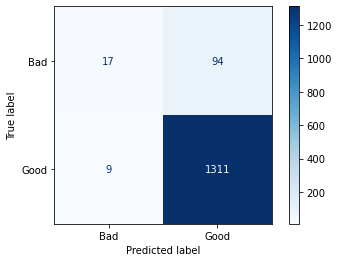

In [53]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')